In [2]:
from datetime import datetime, timedelta
from typing import Optional
from loguru import logger
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from scipy.stats import chi2_contingency
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.svm import SVR
from scipy.stats import poisson


# Problematic:
I need to calculate, for a specific user, the probability of buying at least one product from subfamily -4829876793851668777 during the next 14 days.

Since we don't have information, I assume that we are trying to calculate this value for a future date in 2024 (available data 2021, 2022, 2023), left to the user's choice.


To undertake this exercise, two approaches could be considered: taking into account the past consumption history or considering the user profile.

The second option appeared to me to be the most relevant for this type of problem (I will come back to it later). But I prefer to work on historical analysis.

The reasons are:
* There are not enough indications about the various information present (different columns of the dataset), and I do not know how they are correlated.     For example, are there more sales in this store_id because the store is larger, or is there simply more people around (confounding factor)?
*  To create  user profile we need information like gender age, profession (what we don't have here, excepted gender)
* It does not answer the question of estimating for a user (who is characterized by their purchasing profile historics rather than their group).

My analysis will therefore focus on past consumption analysis to answer the question.

However:
In the case of the subfamily -4829876793851668777, as we will see later, purchases are very localized and punctual, which makes historical analysis comparatively much less reliable than an analysis based on the user's profile.

# Importing different datasets that I will be using
* Import all the information related to a subfamily (as parameter).
* Merging datasets based on different primary keys.
* Adding a quantity column = 1 to indicate that each row corresponds to 1 purchase.
* function: display: displays the general trend of this data for a specific year: the mean (over 2 weeks) and the mooving average (over 2 weeks).
* function: display_years: display the mooving average over the 3 years  
Retrieving general information: start/end dates, number of missing elements, number of considered items.

In [3]:
class PurchaseCustomer():

    def __init__(self, id_custommer: Optional[int] = None, id_subfamily: Optional[int] = None):

        '''
        Load and and merge the parquet files, filter the dataset to focus on a specific subfmily ID
        '''
        
        self.id_subfamily = id_subfamily
        self.id_customer = id_custommer
        df_product = pd.read_parquet(Path('dataset/products.parquet'))
        df_purchase = pd.read_parquet(Path('dataset/purchases.parquet'))
        df_user = pd.read_parquet(Path('dataset/users.parquet'))
        df_purchase['quantity'] = 1
        self.initial_df = pd.merge(df_purchase, df_product,  on='product_id', how='inner')
        self.initial_df = pd.merge(self.initial_df, df_user,  on='user_id', how='inner')


        if id_custommer is not None:
            self.initial_df = self.initial_df[(self.initial_df['user_id'] == id_custommer)]

        if id_subfamily is not None:
            self.initial_df = self.initial_df[(self.initial_df['subfamily'] == id_subfamily)]

        # self.df is for the feneral analysys of the purchasing without other variable
        self.df = self.initial_df[['quantity', 'purchase_date']]
        self.df = self.df.groupby('purchase_date').sum()


        logger.info(f'Selected dataset: {self.df.quantity.sum()} lines')
        logger.info(f'missing data in the  dataset: {sum(self.df.isna().sum())} ')
        logger.info(f"Start date: {self.df.index.min()}")
        logger.info(f"End date: {self.df.index.max()}")

    def display(self, year: str):

        '''
        Displays the general trend of this data for a specific year.
        '''

        fig, axe = plt.subplots(figsize=(12, 8))
        axe.plot(self.df.loc[str(year)].index, self.df.loc[str(year)]['quantity'], label='daily values')
        # axe.plot(self.df.loc[str(year)].resample('2W').mean().index, self.df.loc[str(year)].resample('2W').mean()['quantity'], label='Average 2 weeks', ls=':')


        # NB: mooving average des 2 semaine passees (pas centralise)
        axe.plot(self.df.loc[str(year)].index, self.df.loc[str(year)]['quantity'].rolling(window=14).mean(), label='Rooling average 2 weeks', ls='--')
        plt.legend()
        plt.show()

    def display_years(self):

        '''
        Display the mooving average over the 3 years.
        NB: mooving average of the last 2 weeks: 
        the value at the 14th February matches with the values from (1st to 14th)
        '''

        fig, axe = plt.subplots(figsize=(12, 8))

        
        axe.plot(self.df.loc[str(2021)].index, self.df.loc[str(2021)]['quantity'].rolling(window=14).mean(), label='Rooling average 2 weeks 2021', ls='--')
        axe.plot(self.df.loc[str(2022)].index, self.df.loc[str(2022)]['quantity'].rolling(window=14).mean(), label='Rooling average 2 weeks 2022', ls='--')
        axe.plot(self.df.loc[str(2023)].index, self.df.loc[str(2023)]['quantity'].rolling(window=14).mean(), label='Rooling average 2 weeks 2023', ls='--')
        plt.legend()
        plt.show()

dataset = PurchaseCustomer(id_subfamily=-4829876793851668777)

2024-04-11 10:40:31.996 | INFO     | __main__:__init__:30 - Selected dataset: 102584 lines
2024-04-11 10:40:31.998 | INFO     | __main__:__init__:31 - missing data in the  dataset: 0 
2024-04-11 10:40:32.000 | INFO     | __main__:__init__:32 - Start date: 2020-05-04 00:00:00
2024-04-11 10:40:32.001 | INFO     | __main__:__init__:33 - End date: 2024-03-26 00:00:00


In [4]:
dataset.initial_df.head(5)

,purchase_date,user_id,order_id,store_id,discount,product_id,quantity,color,family,subfamily,universe,rayon,gender_id,creation_store_id
27,2023-08-07,-208097144815479550,4151005342040669547,-8126477362844640768,False,-1549412739406257435,1,6.243788e+18,-4829876793851668777,-4829876793851668777,-8064037300978619555,-7555690729656732925,2,-8126477362844640768
40,2023-12-15,-436712033263805950,-742768962004221359,-8126477362844640768,True,6138388809957173921,1,2.820042e+17,-4829876793851668777,-4829876793851668777,-8064037300978619555,-7555690729656732925,2,-8126477362844640768
57,2021-12-21,4614290325649920770,-7547443944375004829,-8126477362844640768,False,2762401026675669815,1,-8.267375e+18,-4829876793851668777,-4829876793851668777,-8064037300978619555,-7555690729656732925,2,-8126477362844640768
69,2021-12-21,4614290325649920770,-7547443944375004829,-8126477362844640768,False,2762401026675669815,1,-8.267375e+18,-4829876793851668777,-4829876793851668777,-8064037300978619555,-7555690729656732925,2,-8126477362844640768
146,2021-12-07,3997591580212979970,-8329571796122335166,-8126477362844640768,False,-2979832297030750599,1,2.820042e+17,-4829876793851668777,-4829876793851668777,-8064037300978619555,-7555690729656732925,2,-8126477362844640768


In [ ]:
# Analyse of the data (refer comments at the next cell)

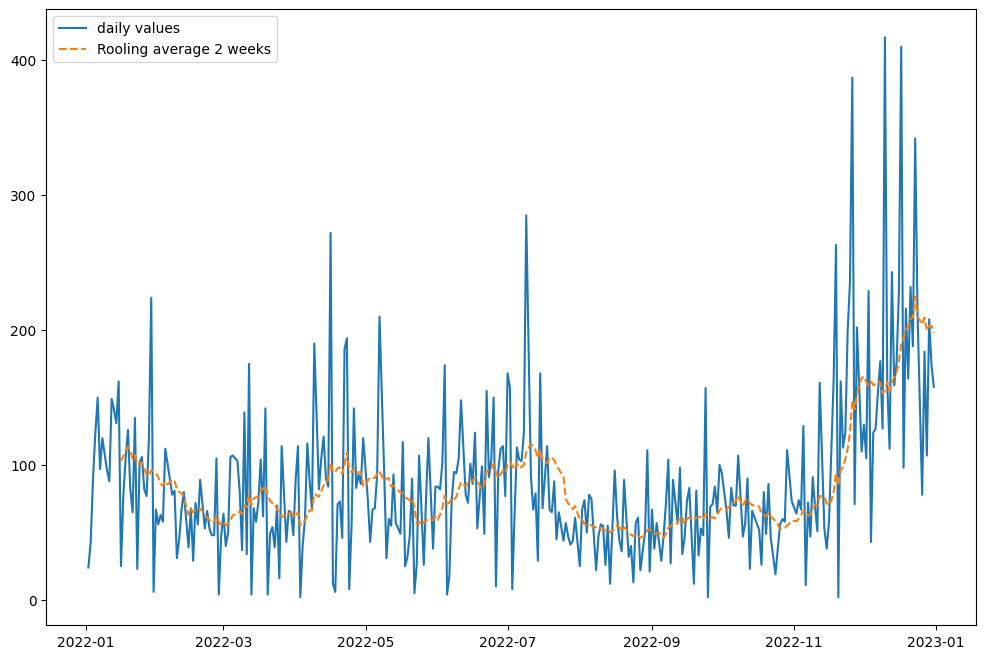

2024-04-11 02:01:02.716 | INFO     | __main__:<module>:3 - Subfamily: -4829876793851668777
2024-04-11 02:01:02.747 | INFO     | __main__:<module>:4 - Variance: 4684.173308321569
2024-04-11 02:01:02.747 | INFO     | __main__:<module>:5 - Average: 82.33065810593901


<Axes: xlabel='quantity'>

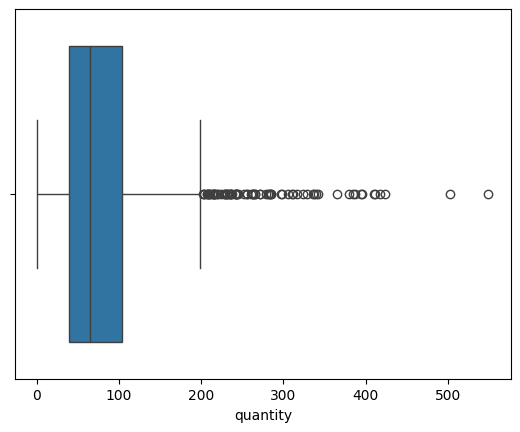

In [5]:
year = '2022'
dataset.display(year)
logger.info(f'Subfamily: {dataset.id_subfamily}')
logger.info(f'Variance: {dataset.df.quantity.var()}')
logger.info(f'Average: {dataset.df.quantity.mean()}')
sns.boxplot(x=dataset.df["quantity"])


# First sight:
* On a specific year, there is no particular seasonality.
* The variance is extremely high, especially when comparing the mean error to the mean.
* Additionally, numerous outliers are observed: these correspond to specific days when large purchases are made, possibly attributed to sales days. But i don't have this information.
I will analyze it in the next cell:

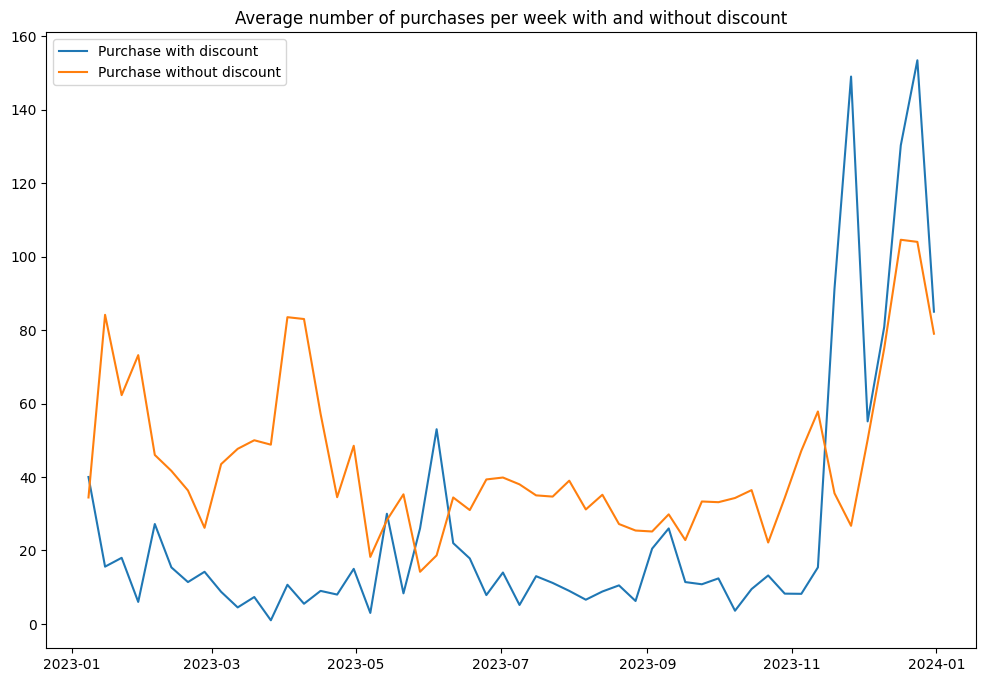

2024-04-11 02:02:53.966 | INFO     | __main__:<module>:24 - Average number of purchases for user with discount: 6.057265692175409
2024-04-11 02:02:53.966 | INFO     | __main__:<module>:25 - Average number of purchases for user without discount: 6.655567631656951


In [6]:


df_true = dataset.initial_df[(dataset.initial_df['discount'] == True)]
df_false = dataset.initial_df[(dataset.initial_df['discount'] == False)]

df_true_user = df_true[['quantity', 'user_id']]
df_false_user = df_false[['quantity', 'user_id']]
df_false_user = df_false_user.groupby('user_id').sum()
df_true_user = df_true_user.groupby('user_id').sum()

df_true = df_true[['quantity', 'purchase_date']]
df_false = df_false[['quantity', 'purchase_date']]
df_true =df_true.groupby('purchase_date').sum()
df_false =df_false.groupby('purchase_date').sum()


fig, axe = plt.subplots(figsize=(12, 8))

axe.plot(df_true.loc[str(2023)].resample('W').mean().index, df_true.loc[str(2023)]['quantity'].resample('W').mean(), label='Purchase with discount')
axe.plot(df_false.loc[str(2023)].resample('W').mean().index, df_false.loc[str(2023)]['quantity'].resample('W').mean(), label='Purchase without discount')
plt.title('Average number of purchases per week with and without discount')
plt.legend()
plt.show()
df_true_user

logger.info(f'Average number of purchases for user with discount: {df_true_user["quantity"].mean()}')
logger.info(f'Average number of purchases for user without discount: {df_false_user["quantity"].mean()}')

# Impact of the discount
Thus, we observe that discounts have an impact, but :
* it is neither correlated to a specific time of the year (discount all the year)
* nor to the buyer's profile (if we buy a lot during one day) : the average purchases number per user is almost the same with and without discount.
Therefore, I will not be using this element in the context of my analysis.

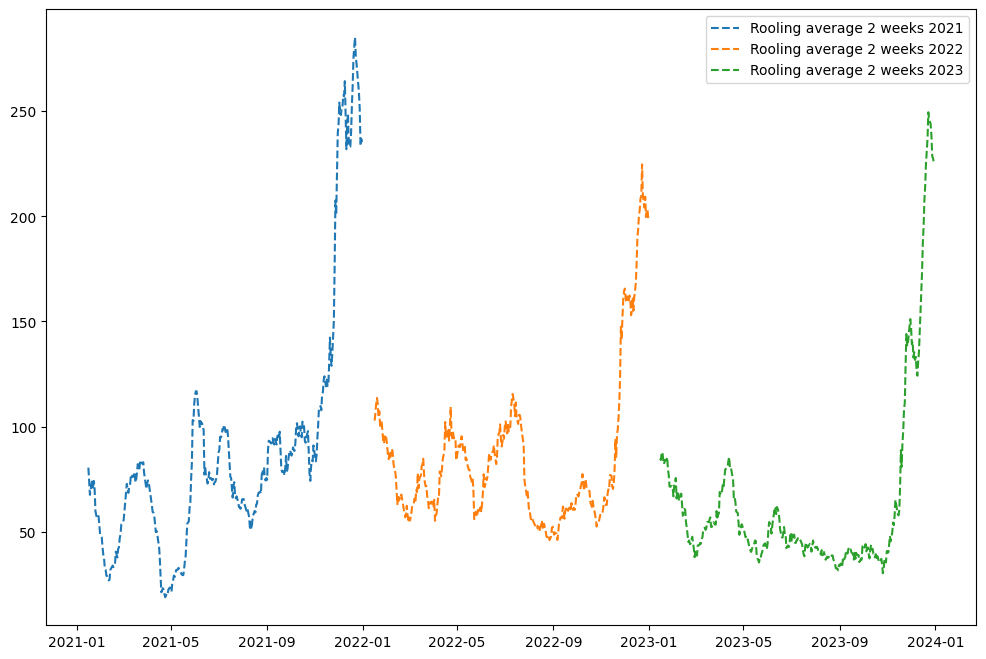

In [7]:
dataset.display_years()

# Seasonality
* If we observe the data over the year, however, we notice an annual seasonality without apparent trend or cycle. 
* The sasonality is obvious in 2021 and 2022, in 2023 is a bit different. Maybe the covid  had an impact of these purchase in 2021 and 2022.
* I can hypothesize that its sales follow some kind of seasonality that should be observable for each user_id. I will try to use this characteristic to make my predictions.


# Strategy
In order to measure the probability on day n of making at least 1 purchase during the  following n+14 days, I will aim to estimate, on average per day, the number of purchases over the next 14 days (rolling average over 14 days). Then, using the Poisson distribution with parameter lambda equal to the defined average value, I will calculate the probability of obtaining 1 or more purchases, which is equal to 1 minus the probability of obtaining 0 purchases.

Therefore, I will create a dataset comprising n time series over the 3 years at my disposal. 
Each time series depends on the purchasing profile of a user analyzed.

The impact of gender and creation store reveals a certain correlation (refer to the end of the notebook). 
However, in my time series approach, I will not incorporate them into my model, as this information is embedded in the time series based on the purchasing profile.

<Axes: xlabel='quantity'>

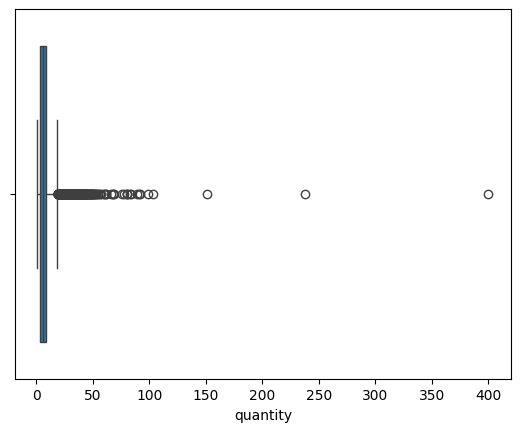

In [8]:
# Creation of the dataset
df = dataset.initial_df[['quantity', 'user_id']]
df_group = df.groupby('user_id').sum()
sns.boxplot(x=df_group["quantity"])


# Dataset creation
We observe that on average, a user purchases 6 items over 3 years, which complicates  prediction with annual seasonality. Fortunately, there are many high-volume buyers (outliers).

To create my dataset, I will select users who 
* have purchased a sufficient number of items 
* spread sufficiently over time (to catch a pattern of seasonality)
* while maximizing the number of users (to create a sufficiently large dataset).

I must therefore define the optimal minimum purchase value to maximize the number of buyers. I will try several values:  [2,3, 4,5, 6, 8, 12, 15, 20] 
I will also ensure that these buyers have made purchases at least 5 times at different points in time to try to capture seasonality over the 3 years.


In [13]:
# Creation of the dataset
class SplitDataset():
    def __init__(self, fulldataset: PurchaseCustomer, min_purchase: int, min_occ: int = 0):

        '''
        Make a selection of the best user profils for my analysys, considaring these parameters:
        min_purchase: minimum number of purchases to consider a user_id in the dataset
        min_occ: minimum number of occurrences of purchase
        '''
        
        df = fulldataset.initial_df

        # Creation de la date range journaliere piur completer les donnee manquantes
        start_date = df.purchase_date.min()
        end_date = df.purchase_date.max()
        date_range = pd.date_range(start=start_date, end=end_date, freq='D')
        empty_data = pd.DataFrame(index=date_range)
        user_groups = df.groupby('user_id')
        self.df_users = {}

        # split the dataset by user
        for user, df_group in tqdm(user_groups, desc='Loading of the user s profil'):
            df_group = df_group.groupby('purchase_date').sum()
            # If not enought purchase, remove the user
            if df_group['quantity'].sum() < min_purchase:
                continue

            # to avoid all the purchase done the sane day (we try to find a seasonality)
            if len(df_group) < min_occ:
                continue

            # create standart x axes of time and add the datas (0 if no value)
            df_group = pd.merge(empty_data, df_group['quantity'], left_index=True, right_index=True, how='left')
            df_group = df_group.fillna(0)
            df_group['quantity'] = df_group['quantity'].rolling(window=14).mean()
            self.df_users[user] = df_group

        logger.info(f'{len(self.df_users)} user s profile loaded')

    def display(self, max: int):

        fig, axe = plt.subplots(figsize=(12, 8))

        for index, df in enumerate(self.df_users.values()):
            if index < max:
                # NB: mooving average des 2 semaine passees (pas centralise)
                axe.plot(df.index, df['quantity'], lw=0.2)
        plt.legend()
        plt.show()


In [14]:
print('number of user initially', dataset.initial_df['user_id'].nunique())
for min_purchase in [2,3, 4,5, 6, 8, 12, 15, 20]:
    full_dataset_roll_14 = SplitDataset(dataset, min_purchase)
    total_purchase = 0
    for index, df in enumerate(full_dataset_roll_14.df_users.values()):
        total_purchase = total_purchase + (df['quantity'].sum())
    print(f'User with min purchase = {min_purchase}, Total amount of purchase involved for these user:', total_purchase)

number of user initially 14102


Loading of the user s profil: 100%|██████████| 14102/14102 [00:33<00:00, 425.84it/s]
2024-04-11 10:42:39.766 | INFO     | __main__:__init__:38 - 12813 user s profile loaded


User with min purchase = 2, Total amount of purchase involved for these user: 101143.28571428574


Loading of the user s profil: 100%|██████████| 14102/14102 [00:31<00:00, 450.88it/s]
2024-04-11 10:43:12.079 | INFO     | __main__:__init__:38 - 11150 user s profile loaded


User with min purchase = 3, Total amount of purchase involved for these user: 97823.35714285716


Loading of the user s profil: 100%|██████████| 14102/14102 [00:28<00:00, 491.93it/s]
2024-04-11 10:43:41.655 | INFO     | __main__:__init__:38 - 10402 user s profile loaded


User with min purchase = 4, Total amount of purchase involved for these user: 95584.50000000003


Loading of the user s profil: 100%|██████████| 14102/14102 [00:25<00:00, 546.78it/s]
2024-04-11 10:44:08.446 | INFO     | __main__:__init__:38 - 8334 user s profile loaded


User with min purchase = 5, Total amount of purchase involved for these user: 87327.64285714288


Loading of the user s profil: 100%|██████████| 14102/14102 [00:25<00:00, 552.18it/s]
2024-04-11 10:44:34.843 | INFO     | __main__:__init__:38 - 7903 user s profile loaded


User with min purchase = 6, Total amount of purchase involved for these user: 85176.9285714286


Loading of the user s profil: 100%|██████████| 14102/14102 [00:21<00:00, 641.19it/s]
2024-04-11 10:44:57.618 | INFO     | __main__:__init__:38 - 5279 user s profile loaded


User with min purchase = 8, Total amount of purchase involved for these user: 69166.71428571429


Loading of the user s profil: 100%|██████████| 14102/14102 [00:18<00:00, 744.51it/s]
2024-04-11 10:45:17.167 | INFO     | __main__:__init__:38 - 2503 user s profile loaded


User with min purchase = 12, Total amount of purchase involved for these user: 44764.57142857143


Loading of the user s profil: 100%|██████████| 14102/14102 [00:17<00:00, 815.12it/s]
2024-04-11 10:45:34.800 | INFO     | __main__:__init__:38 - 1237 user s profile loaded


User with min purchase = 15, Total amount of purchase involved for these user: 28964.999999999996


Loading of the user s profil: 100%|██████████| 14102/14102 [00:16<00:00, 849.97it/s]
2024-04-11 10:45:51.693 | INFO     | __main__:__init__:38 - 667 user s profile loaded


User with min purchase = 20, Total amount of purchase involved for these user: 19485.0


* Thus, with a minimum purchase count of 6, we capture approximately 80% of the total purchases, but we only include 50% of the users. This demonstrates that 50% of users are not regular buyers, making it difficult to predict anything.

* One approach to integrate them (this 50% 'one shot purchaser') would be to broaden the question to include a user type and thereby create characteristics by profile (as explained in the introduction). Unfortunately I don't have the information to profil user
This approach would be different as we would not be using time series.

In [15]:

full_dataset_roll_14 = SplitDataset(dataset, 6, 5)

Loading of the user s profil: 100%|██████████| 14102/14102 [00:16<00:00, 858.78it/s]
2024-04-11 10:46:08.313 | INFO     | __main__:__init__:38 - 192 user s profile loaded



* Now the relevant user_id for my study are selected, I will split my dataset into train and validation sets.

* The objective of my model is to use the first 2 years (2021 and 2022) of purchase history to predict the third year (2023).
* As I mentioned previously, the limitation of this approach is that the year 2023 is slightly different from the years 2021 and 2022.

In [ ]:
# split of the dataset a the first 2 years
X = [df['2021-01-01':'2023-01-01'] for df in list(full_dataset_roll_14.df_users.values())]
y = [df['2023-01-01':'2024-01-01'] for df in list(full_dataset_roll_14.df_users.values())]
X_train, X_val, y_train , y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = pd.concat(X_train, axis=1).T
X_val = pd.concat(X_val, axis=1).T
y_train = pd.concat(y_train, axis=1).T
y_val = pd.concat(y_val, axis=1).T




The model I am using is a Random Forest. A linear model or SVM has been tested, but without yielding good results. As expected, the non-linear aspect of the Random Forest model fits better for this type of prediction.

In [17]:

model = RandomForestRegressor(n_estimators=7, random_state=42)
model.fit(X_train, y_train)

# Prediction
predictions = model.predict(X_val)

# Quadratic error
mse = mean_squared_error(y_val, predictions)
print('MSE:', mse)

MSE: 0.013573392998099064


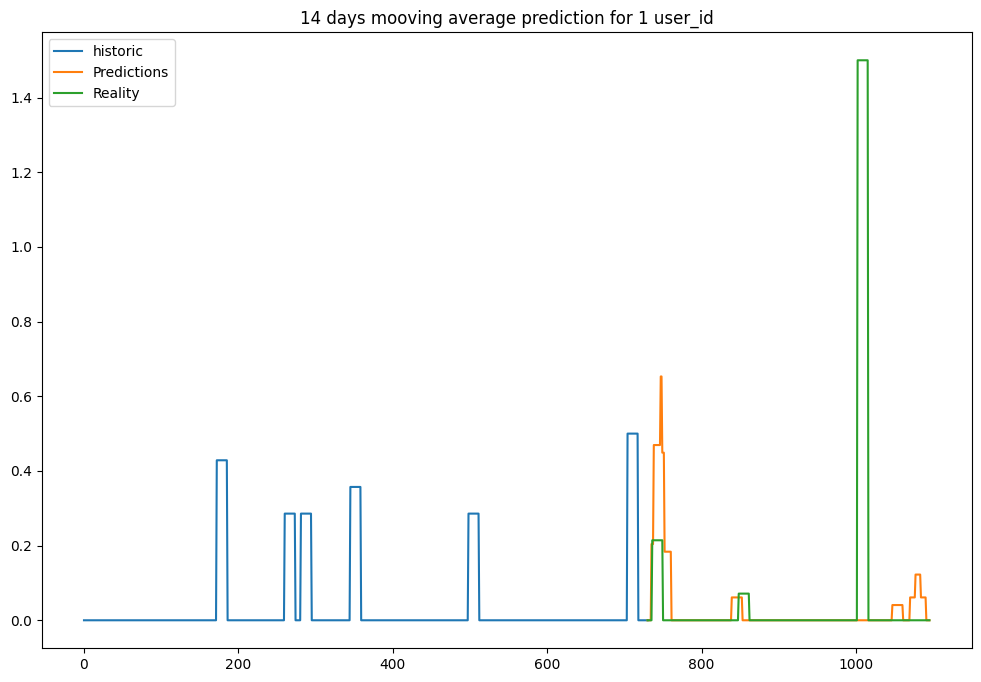

In [16]:

index = 25
x_test = pd.DataFrame(X_val.iloc[index,:]).T
abcsiss_test = range(x_test.shape[1])


trues =  pd.DataFrame(y_val.iloc[index,:]).T.to_numpy().flatten()
predictions = model.predict(x_test).flatten()
abcsiss_predictions = range(abcsiss_test[-1], len(predictions)+abcsiss_test[-1])

# abcsiss_test = np.array(abcsiss_test)
# abcsiss_predictions = np.array(abcsiss_predictions)


fix, ax = plt.subplots(figsize=(12, 8))
ax.plot(abcsiss_test, x_test.to_numpy().flatten(), label='historic')
ax.plot(abcsiss_predictions, predictions, label='Predictions')
ax.plot(abcsiss_predictions, trues, label='Reality')
plt.title('14 days mooving average prediction for 1 user_id')
plt.legend()

With the current input data, the predictions are not of very good quality. This type of approach would work better if there were more (more often) purchases per client.

With the profil of production of user (profile of the aveage rooling mean) we can plan the probability asked with the poissson law.

In input we should submit the purchase historic + the date we want to get the probabilities of predictions

In [18]:
def get_prediction_poisson_at_lest_one(lambda_val: float):
    '''
    Get the probabilities of 'at least one' with a poisson law
    '''
    return 1 - poisson.pmf(0, lambda_val)

def predict_prob(x: pd.DataFrame):
    '''
    Make prediction on the next year and convert the result in probabilities
    :param x: 1 row × 731 columns (2 years of data)
    :return:
    '''

    predictions = model.predict(x).flatten()
    periods = len(predictions)
    # print(predictions)
    # - 14 days because the rooling average mean is at the end of the considerated period
    start_date = x.T.index.max()
    predictions_prob = pd.DataFrame({'result':np.vectorize(get_prediction_poisson_at_lest_one)(predictions)},
                                    index=pd.date_range(start=start_date-timedelta(days=14),periods=periods,freq='D'))
    

    return predictions_prob

result = predict_prob(pd.DataFrame(X_val.iloc[0,:]).T)
print(result.loc['2023-8', 'result'])





2023-08-01    0.000000
2023-08-02    0.000000
2023-08-03    0.000000
2023-08-04    0.000000
2023-08-05    0.000000
2023-08-06    0.000000
2023-08-07    0.000000
2023-08-08    0.000000
2023-08-09    0.000000
2023-08-10    0.000000
2023-08-11    0.000000
2023-08-12    0.000000
2023-08-13    0.000000
2023-08-14    0.000000
2023-08-15    0.059388
2023-08-16    0.059388
2023-08-17    0.059388
2023-08-18    0.059388
2023-08-19    0.078390
2023-08-20    0.078390
2023-08-21    0.078390
2023-08-22    0.078390
2023-08-23    0.078390
2023-08-24    0.078390
2023-08-25    0.078390
2023-08-26    0.078390
2023-08-27    0.078390
2023-08-28    0.078390
2023-08-29    0.020201
2023-08-30    0.020201
2023-08-31    0.020201
Freq: D, Name: result, dtype: float64


# Conclusion

Here are the translations:

* It is easy to perform the same analysis with the other value of the subfamily (just the comments would need to be adapted).

* Several approaches were possible to solve this problem, but given the nature of the information at my disposal, I judged that the purchase history approach was the best.

* The other exploitable columns (creation_store_id, store id, etc.) show correlations (cf shi2 test below) with the number of purchases, but I cannot exploit this information without further details.

* The method based on historical analysis works well if we have enough data on purchase history.

* The user_id here does not provide a very rich history, so the method is not ideal. In addition, 50% percent of the purchaser are one shot purchaser, making prediction work very complicated.

* The ideal would be to create a hundred different profiles (age, profession, gender, etc.) to group the profiles and improve the quality of the results.


I propose below a second technique to solve this problem.


# Option 2
The strategy of Option 2 is to obtain a prediction curve for each user not by predicting their past purchases, but by considering each year independently. The objective is :
* to obtain a consumption profile for all users (on average compared to previous years)
* then divide this value by the average number of users for the year under consideration.

Then, I reapply the previous technique to obtain the desired probabilities.

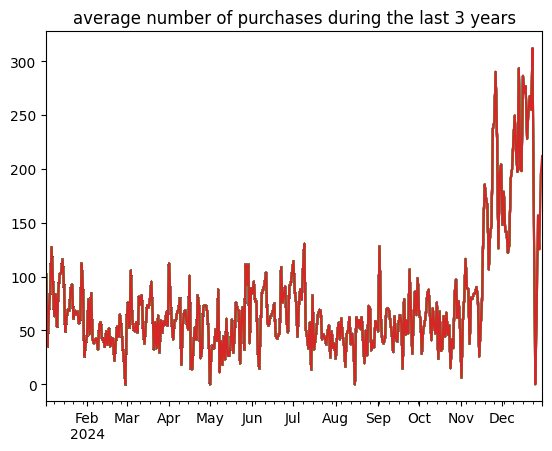

In [19]:
df_2021 =  dataset.df.loc[str(2021)]
df_2021.index = df_2021.index.map(lambda x: x.replace(year=2024))

df_2022 =  dataset.df.loc[str(2022)]
df_2022.index = df_2022.index.map(lambda x: x.replace(year=2024))

df_2023 =  dataset.df.loc[str(2023)]
df_2023.index = df_2023.index.map(lambda x: x.replace(year=2024))

# select the common range time for the 3 parts
# for the start date
start_date = max(min(df_2021.index), min(df_2022.index) ,min(df_2023.index))
end_date = min(max(df_2021.index), max(df_2022.index) ,max(df_2023.index))

date_range = pd.date_range(start=start_date, end=end_date, freq='D')


mean_purchase_3_years = pd.DataFrame(index=date_range)
for index_date, row in mean_purchase_3_years.iterrows():
    # make sure there is value for every day (or 0)
    if index_date not in df_2021.index:
        df_2021.loc[index_date, 'quantity'] = 0
    if index_date not in df_2022.index:
        df_2022.loc[index_date, 'quantity'] = 0
    if index_date not in df_2023.index:
        df_2023.loc[index_date, 'quantity'] = 0
    
    # Create the mean
    mean_purchase_3_years.loc[index_date, 'mean_3_y'] = (df_2021.loc[index_date, 'quantity'] +  df_2022.loc[index_date, 'quantity'] + df_2023.loc[index_date, 'quantity']) / 3
    mean_purchase_3_years.mean_3_y.plot(title = 'average number of purchases during the last 3 years')



Logically, this curve follows the same trend as the curves presented at the beginning of the exercise.

In [7]:
# Calculate the mean number of different user_id per year
df_user = dataset.initial_df[['quantity', 'user_id', 'purchase_date']]
df_user= df_user.groupby('user_id').min()
df_user= df_user.groupby('purchase_date').sum()

nbr_user_2021 = len( df_user.loc[str(2021)])
nbr_user_2022 = len( df_user.loc[str(2022)])
nbr_user_2023 = len( df_user.loc[str(2023)])
average_number_user_year = (nbr_user_2021 + nbr_user_2022 + nbr_user_2023)/3
logger.info(f'Mean number of users per year: {average_number_user_year}')

2024-04-11 10:41:22.577 | INFO     | __main__:<module>:10 - Mean number of users per year: 320.6666666666667


<Axes: title={'center': 'Rolling mean 14d number of purchases per user'}>

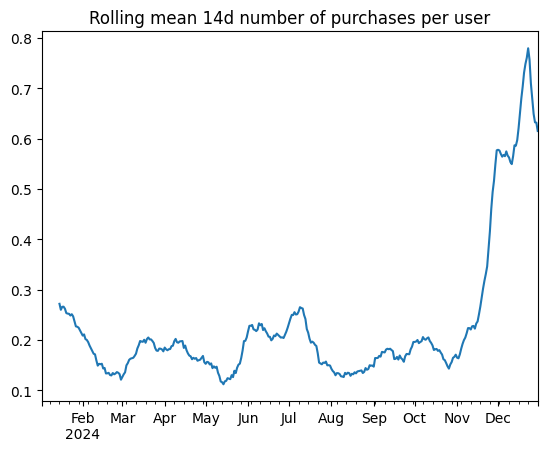

In [20]:
# calculation of the rolling  on 14 days mean purchases per user
mean_purchase_3_years['roll_mean_purchase_14d'] = mean_purchase_3_years['mean_3_y'].rolling(window=14).mean()

# get the rolling mean 14 days purchase / user_id
mean_purchase_3_years['roll_mean_purchase_per_user_14d'] = mean_purchase_3_years['roll_mean_purchase_14d'] /average_number_user_year
mean_purchase_3_years['roll_mean_purchase_per_user_14d'].plot(title='Rolling mean 14d number of purchases per user')



Now we can use this purchasing profile with the function defined above to propose a second solution to the problem.

<Axes: title={'center': 'Probabilies of at least 1 purchase for any user_id during the next 14 days'}>

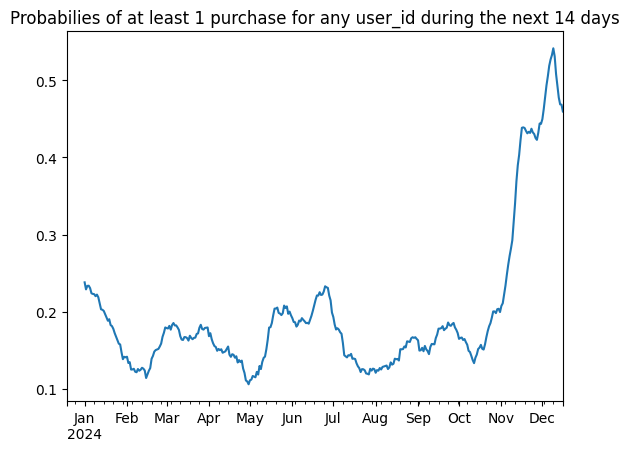

In [21]:
predictions_prob = pd.DataFrame({'result':np.vectorize(get_prediction_poisson_at_lest_one)(mean_purchase_3_years['roll_mean_purchase_per_user_14d'])},
                                    index=pd.date_range(start=start_date-timedelta(days=14),end=end_date-timedelta(days=14),freq='D'))
predictions_prob.result.plot(title='Probabilies of at least 1 purchase for any user_id during the next 14 days')


# Conclusion 2

* This technique appears to be more suitable for obtaining more precise results.
* The downside of this method is that there are significant outliers in the buyer profile, which are smoothed out by this approach.


In [ ]:

# # creation store id depend also of the user
# dataset.initial_df['creation_store_id'].value_counts()
# # It seems that there is a correlation also

# # Now let see  if store_id  and creation_store_id are strongly correlated (as we could expect)
# # I use the shi2 test for to measure the dependance of 2 categorical variable
# print('number values for each creation stor id', dataset.initial_df['creation_store_id'].value_counts())
# print('number values for each store id', dataset.initial_df['store_id'].value_counts())
# # more than 5 values per category : important for shi2 test
# contingency_table = pd.crosstab(dataset.initial_df['creation_store_id'], dataset.initial_df['store_id'])
# print(contingency_table)
# chi2, p, dof, expected = chi2_contingency(contingency_table)
# print("Test statistic:", chi2)
# print('dof:', dof)
# print("p-value:", p)
# # La p value de 0 indique quil n'y a aucune chance d'obtenir de tel resultat si les variable n'etait pas coorele et dans ce cas dependante (contenu des type de variable)

In [ ]:
# # A hight value of shi2 test (with p value = 0) indicates that the both variable are not independant

# contingency_table = pd.crosstab( dataset.initial_df['creation_store_id'],  dataset.initial_df['store_id'])
# # Tracer le heatmap du tableau de contingence
# plt.figure(figsize=(10, 6))
# sns.heatmap(contingency_table, cmap="YlGnBu")
# plt.show()
# # Conclusion: confirmation   store id place of purchase correlated so not usefull for our study